In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

In [6]:
def load_cifar10(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    (train_validation_images, train_validation_labels), (test_images, test_labels) = cifar10.load_data()
    
    train_validation_ds = tf.data.Dataset.from_tensor_slices((train_validation_images, train_validation_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    
    n_train_validation = train_validation_images.shape[0]
    train_ratio = 0.8
    n_train = int(n_train_validation * train_ratio)
    n_validation = n_train_validation - n_train
    train_ds = train_validation_ds.take(n_train)
    remaining_ds = train_validation_ds.skip(n_train)
    validation_ds = remaining_ds.take(n_validation)
    n_test = test_images.shape[0]
    
    std = tf.reshape((0.2023, 0.1994, 0.2010), shape = (1, 1, 3))
    mean = tf.reshape((0.4914, 0.4822, 0.4465), shape = (1, 1, 3))
    
    def train_prep(x, y):
        x = tf.cast(x, tf.float32) / 255.
        x = tf.image.random_flip_left_right(x)
        x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40)
        x = tf.image.random_crop(x, (32, 32, 3))
        x = (x - mean) / std
        return x, y
    
    def test_prep(x, y):
        x = tf.cast(x, tf.float32) / 255.
        x = (x - mean) / std
        return x, y
    
    train_ds = train_ds.map(train_prep).shuffle(1000).batch(TRAIN_BATCH_SIZE)
    validation_ds = validation_ds.map(test_prep).shuffle(1000).batch(TEST_BATCH_SIZE)
    test_ds = test_ds.map(test_prep).shuffle(1000).batch(TEST_BATCH_SIZE)
    
    return train_ds, validation_ds, test_ds

In [7]:
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128

train_ds, validation_ds, test_ds = load_cifar10(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

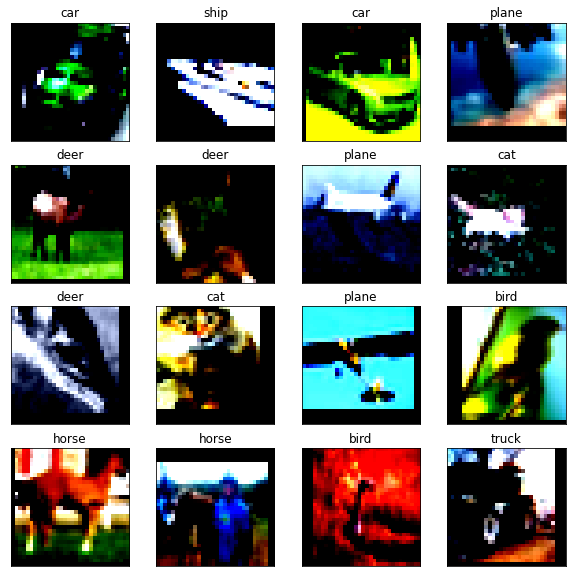

In [9]:
train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(4, 4, figsize = (10, 10))

for ax_idx, ax in enumerate(axes.flat):
    ax.imshow(images[ax_idx, ...].numpy(), 'gray')
    ax.set_title('{}'.format(class_names[labels[ax_idx, 0]]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if ax_idx > 15:
        break

In [31]:
class Residual(Model):
    def __init__(self, num_channels, use_1x1conv = False, strides = 1):
        super().__init__()
        self.conv1 = Conv2D(num_channels, padding = 'same', kernel_size = 3, strides = strides)
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(num_channels, kernel_size = 3, padding = 'same')
        self.bn2 = BatchNormalization()
        self.down_sample = None
        if use_1x1conv:
            self.down_sample = Conv2D(num_channels, kernel_size = 1, strides = strides)
            
    def call(self, x):
        y = relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.down_sample is not None:
            x = self.down_sample(x)
        y += x
        return relu(y)

In [32]:
class ResnetBlock(Layer):
    def __init__(self, num_channels, num_residuals, first_block = False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals + 1):
            if i == 0 and not first_block:
                self.residual_layers.append(Residual(num_channels, use_1x1conv = True, strides = 2))
            else:
                self.residual_layers.append(Residual(num_channels))
                
    def call(self, x):
        for layer in self.residual_layers.layers:
            x = layer(x)
        return x

In [33]:
class FirstBlock(Layer):
    def __init__(self, **kwargs):
        super(FirstBlock, self).__init__(**kwargs)
        self.conv = Conv2D(16, kernel_size = 3, strides = 2, padding = 'same')
        self.bn = BatchNormalization()
        self.ac = Activation('relu')
        self.pool = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')
        
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.ac(x)
        x = self.pool(x)
        return x

In [34]:
class Cifar10_Resnet20(Model):
    def __init__(self):
        super(Cifar10_Resnet20, self).__init__()
        
        self.fb1 = FirstBlock()
        self.rb1 = ResnetBlock(16, 2, first_block = True)
        self.rb2 = ResnetBlock(32, 2)
        self.rb3 = ResnetBlock(64, 2)
        self.gap = GlobalAveragePooling2D()
        self.d1 = Dense(10, activation = 'softmax')
        
    def call(self, x):
        x = self.fb1(x)
        x = self.rb1(x)
        x = self.rb2(x)
        x = self.rb3(x)
        x = self.gap(x)
        x = self.d1(x)
        return x

In [35]:
def load_metrics():
    global train_loss, train_acc
    global validation_loss, validation_acc
    global test_loss, test_acc
    
    train_loss = Mean()
    validation_loss = Mean()
    test_loss = Mean()
    train_acc = SparseCategoricalAccuracy()
    validation_acc = SparseCategoricalAccuracy()
    test_acc = SparseCategoricalAccuracy()

In [36]:
def trainer():
    global train_ds, model, loss_object, optimizer
    global train_loss, train_acc
    for x, y in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(y, predictions)
            
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        train_loss(loss)
        train_acc(y, predictions)

In [37]:
def validation():
    global validation_ds, model, loss_object
    global validation_loss, validation_acc
    
    for x, y in validation_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)
        
        validation_loss(loss)
        validation_acc(y, predictions)

In [38]:
def train_reporter():
    global epoch
    global train_loss, train_acc
    global validation_loss, validation_acc
    global train_losses, train_accs
    global validation_losses, validation_accs
    
    train_losses.append(train_loss.result())
    train_accs.append(train_acc.result() * 100)
    validation_losses.append(validation_loss.result())
    validation_accs.append(validation_acc.result() * 100)
    
    template = 'Train Loss: {:.4f}\t Train Accuracy : {:.2f}%\n' + 'Validation Loss: {:.4f}\t Validation Accuracy : {:.2f}%\n'
    
    print(template.format(train_loss.result(), train_acc.result() * 100, validation_loss.result(), validation_acc.result()))
    
    train_loss.reset_states()
    train_acc.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()

In [47]:
def plot_loss():
    global train_losses, train_accs
    global validation_losses, validation_accs
    
    fig, axes = plt.subplots(2, 1)
    
    axes[0].plot(train_losses, label = 'Train loss')
    axes[0].plot(validation_losses, label = 'Validation loss')
    axes[0].set_ylabel('Crossentropy')
    axes[0].legend()
    
    axes[1].plot(train_accs, label = 'Train accuracy')
    axes[1].plot(validation_accs, label = 'Validation accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].set_xlabel('Epochs')

In [40]:
def tester():
    global test_ds, model, loss_object
    global test_loss, test_acc
    
    for x, y in test_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)
        
        test_loss(loss)
        test_acc(y, predictions)
        
        template = 'Test Loss: {:.4f}\t Test Accuracy : {:.2f}%\n'
        
    print(template.format(test_loss.result(), test_acc.result() * 100))

In [41]:
model = Cifar10_Resnet20()

In [42]:
load_metrics()

loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate = 0.01, momentum = 0.9)

EPOCHS = 10

train_losses, train_accs = [], []
validation_losses, validation_accs = [], []

for epoch in range(EPOCHS):
    trainer()
    validation()
    print('Epoch: {}'.format(epoch + 1))
    train_reporter()

Epoch: 1
Train Loss: 1.8767	 Train Accuracy : 30.90%
Validation Loss: 1.5586	 Validation Accuracy : 0.43%

Epoch: 2
Train Loss: 1.5645	 Train Accuracy : 42.28%
Validation Loss: 1.4344	 Validation Accuracy : 0.48%

Epoch: 3
Train Loss: 1.4521	 Train Accuracy : 47.18%
Validation Loss: 1.3390	 Validation Accuracy : 0.52%

Epoch: 4
Train Loss: 1.3802	 Train Accuracy : 50.02%
Validation Loss: 1.3231	 Validation Accuracy : 0.53%

Epoch: 5
Train Loss: 1.3184	 Train Accuracy : 52.41%
Validation Loss: 1.2687	 Validation Accuracy : 0.55%

Epoch: 6
Train Loss: 1.2688	 Train Accuracy : 54.38%
Validation Loss: 1.2444	 Validation Accuracy : 0.56%

Epoch: 7
Train Loss: 1.2317	 Train Accuracy : 55.81%
Validation Loss: 1.1743	 Validation Accuracy : 0.58%

Epoch: 8
Train Loss: 1.1913	 Train Accuracy : 57.31%
Validation Loss: 1.2026	 Validation Accuracy : 0.58%

Epoch: 9
Train Loss: 1.1682	 Train Accuracy : 58.35%
Validation Loss: 1.0866	 Validation Accuracy : 0.61%

Epoch: 10
Train Loss: 1.1484	 Train A

In [43]:
tester()

Test Loss: 1.1153	 Test Accuracy : 59.60%



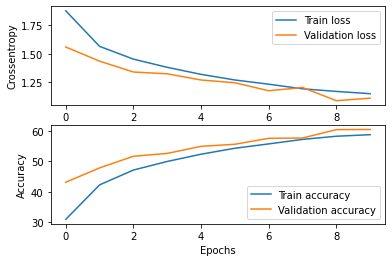

In [48]:
plot_loss()

In [50]:
X = tf.random.uniform(shape = (1, 32, 32, 3))
for layer in Cifar10_Resnet20().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

FirstBlock output shape:	 (1, 8, 8, 16)
ResnetBlock output shape:	 (1, 8, 8, 16)
ResnetBlock output shape:	 (1, 4, 4, 32)
ResnetBlock output shape:	 (1, 2, 2, 64)
GlobalAveragePooling2D output shape:	 (1, 64)
Dense output shape:	 (1, 10)


In [51]:
model.summary()

Model: "cifar10__resnet20_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_block_2 (FirstBlock)  multiple                  512       
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 14304     
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  multiple                 52192     
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  multiple                 206784    
 )                                                               
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                        